# Emergency Facilities Location Prediction

**Step 1:** Prepare Toronto neigbourhood data

In [2]:
import pandas as pd
import numpy as np
import requests

get wiki page  
read table with data into dataframe  
rename column  
remove 'Not Assigned' boroughs  
replace 'Not Assigned' neighborhoods with boroughs values  
group neighbourhoods for the same borough

In [3]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wiki_page = requests.get(wiki_url)
codes_df_list = pd.read_html(io = wiki_page.text, attrs = {'class': 'wikitable'})
codes_df_0 = codes_df_list[0]
codes_df_1 = codes_df_0.rename(columns = {'Postcode': 'PostalCode'})
codes_df_2 = codes_df_1[codes_df_1['Borough'] != 'Not assigned']
codes_df_2['Neighbourhood'] = np.where(codes_df_2['Neighbourhood'] == 'Not assigned', codes_df_2['Borough'], codes_df_2['Neighbourhood'])
neighborhood_df = codes_df_2.groupby(['PostalCode', 'Borough'])['Neighbourhood'].apply(lambda v: ', '.join(v)).reset_index()
neighborhood_df.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


**Step 2:** Prepare neighborhood geo data

read geo data  
rename column

In [4]:
geo_df = pd.read_csv('https://cocl.us/Geospatial_data')
geo_df = geo_df.rename(columns = {'Postal Code': 'PostalCode'})

In [5]:
geo_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
data_with_geo = pd.merge(neighborhood_df, geo_df[['PostalCode', 'Latitude', 'Longitude']], on = 'PostalCode')

In [8]:
data_with_geo.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


**Step 3:** Prepare emergency statistic data

In [9]:
import urllib
import json

get excel file url from open data portal

In [10]:
url = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show'
params = { 'id': 'c21f3bd1-e016-4469-abf5-c58bb8e8b5ce'}
response = urllib.request.urlopen(url, data=bytes(json.dumps(params), encoding='utf-8'))
package = json.loads(response.read())
xls_url = package['result']['resources'][0]['url']
print(xls_url)

http://opendata.toronto.ca/it/com/TPS_Incident_Data_2010-2019.xlsx


get excel file

In [11]:
!wget http://opendata.toronto.ca/it/com/TPS_Incident_Data_2010-2019.xlsx

--2020-02-11 13:44:53--  http://opendata.toronto.ca/it/com/TPS_Incident_Data_2010-2019.xlsx
Resolving opendata.toronto.ca (opendata.toronto.ca)... 206.130.170.86
Connecting to opendata.toronto.ca (opendata.toronto.ca)|206.130.170.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97534332 (93M)
Saving to: ‘TPS_Incident_Data_2010-2019.xlsx’

100%[======================================>] 97,534,332   678KB/s   in 2m 23s 

2020-02-11 13:47:17 (666 KB/s) - ‘TPS_Incident_Data_2010-2019.xlsx’ saved [97534332/97534332]



load annual data in the list of dataframes (takes ~ 3 minutes per sheet)

In [12]:
df_list = []
for year in range(2010, 2020):
    year_df = pd.read_excel('TPS_Incident_Data_2010-2019.xlsx', sheet_name = str(year))
    print(str(year) + ' loaded')
    df_list.append(year_df)

2010 loaded
2011 loaded
2012 loaded
2013 loaded
2014 loaded
2015 loaded
2016 loaded
2017 loaded
2018 loaded
2019 loaded


**Step 4:** combine data

transform and merge statistical data, pay attention that 2010, 2011 and 2017 year data have different columns naming

In [13]:
df_temp = []
year = 2010
for df in df_list:
    df_t = df.drop(columns=['ID', 'Dispatch_Time', 'Incident_Type', 'Priority_Number'])
    if year in [2010, 2011, 2017]:
        df_t = df_t.groupby(['FSA']).sum().reset_index().rename(columns = {'FSA': 'PostalCode', 'Units_Arrived_At_Scene': str(year)})
    else:
        df_t = df_t.groupby(['Forward_Sortation_Area']).sum().reset_index().rename(columns = {'Forward_Sortation_Area': 'PostalCode', 'Units_Arrived_At_Scene': str(year)})
    df_temp.append(df_t)
    data_with_geo = pd.merge(data_with_geo, df_t[['PostalCode', str(year)]], on = 'PostalCode', how = 'left')
    year = year + 1

In [14]:
data_with_geo.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,3303.0,3651.0,3781.0,4020.0,4109.0,4300.0,4497.0,4581.0,4810.0,4890.0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1742.0,1874.0,1854.0,1881.0,1982.0,1935.0,2018.0,2106.0,2225.0,2353.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,4217.0,4762.0,4810.0,4780.0,4949.0,5408.0,5835.0,5606.0,5870.0,5620.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,2073.0,2444.0,2298.0,2190.0,2419.0,2293.0,2364.0,2449.0,2585.0,2546.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1833.0,2012.0,2072.0,2159.0,2348.0,2288.0,2327.0,2529.0,2655.0,2628.0


In [15]:
data_with_geo.shape

(103, 15)

some rows have missing values

In [16]:
data_with_geo.loc[data_with_geo['PostalCode'] == 'M7A']

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
85,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


we can either replace them with mean values either ignore

In [17]:
temp = data_with_geo.loc[data_with_geo['2010'].isnull() == False]

prepare data to further process

In [18]:
agg_dict = {'Latitude':'mean', 'Longitude':'mean', '2010':'sum', '2011':'sum', '2012': 'sum', '2013':'sum', '2014':'sum', '2015':'sum', '2016':'sum', '2017':'sum', '2018':'sum', '2019':'sum'}
data_df = temp.drop(columns = ['PostalCode', 'Neighbourhood']).groupby('Borough').agg(agg_dict).reset_index()

In [19]:
data_df.shape

(10, 13)

In [20]:
data_df

,Borough,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Central Toronto,43.701980,-79.398954,12773.0,14197.0,14453.0,14796.0,16127.0,15645.0,16719.0,16869.0,17599.0,18107.0
1,Downtown Toronto,43.656058,-79.384818,35965.0,38967.0,40856.0,43223.0,45618.0,47672.0,52299.0,54141.0,58866.0,61858.0
2,East Toronto,43.671110,-79.325428,10684.0,10901.0,10893.0,11439.0,11430.0,11376.0,11658.0,11900.0,13231.0,13488.0
3,East York,43.700303,-79.335851,11619.0,12054.0,12129.0,12952.0,13564.0,13493.0,13827.0,14000.0,14398.0,14521.0
4,Etobicoke,43.659333,-79.542967,26935.0,29949.0,29932.0,30493.0,31299.0,31173.0,32793.0,33821.0,35678.0,35529.0
5,North York,43.750727,-79.429338,53327.0,58006.0,58122.0,59289.0,61537.0,61756.0,65029.0,65819.0,69280.0,68274.0
6,Queen's Park,43.667856,-79.532242,2470.0,2908.0,2956.0,2927.0,3045.0,3182.0,3351.0,3268.0,3431.0,3499.0
7,Scarborough,43.766229,-79.249085,44765.0,49333.0,49095.0,51567.0,53077.0,53587.0,55006.0,56499.0,59021.0,58621.0
8,West Toronto,43.652653,-79.449290,19022.0,20759.0,21421.0,21864.0,23432.0,23709.0,24239.0,24539.0,27084.0,27139.0
9,York,43.690797,-79.472633,16776.0,18099.0,17522.0,18102.0,18930.0,18814.0,19427.0,19553.0,20799.0,20980.0


**Step 5:** visualize data gathering result

In [21]:
!conda install -c conda-forge folium=0.6.0 --yes
import folium

print(folium.__version__)

Solving environment: done

# All requested packages already installed.

0.6.0


In [3]:
!conda install -c conda-forge matplotlib

import matplotlib
import matplotlib.pyplot as plt

print(matplotlib.__version__)

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    tk-8.6.10                  |       hed695b0_0         3.2 MB  conda-forge
    matplotlib-3.1.1           |           py36_0           6 KB  conda-forge
    matplotlib-base-3.1.1      |   py36hfd891ef_0         6.7 MB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        10.0 MB

The following NEW packages will be INSTALLED:

    matplotlib:      3.1.1-py36_0         conda-forge
    matplotlib-base: 3.1.1-py36hfd891ef_0 conda-forge

The following packages will be UPDATED:

    certifi:         2019.11.28-py36_0                --> 2019.11.28-py36_

In [33]:
x_years = [*range(2010, 2020)]
x_years

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

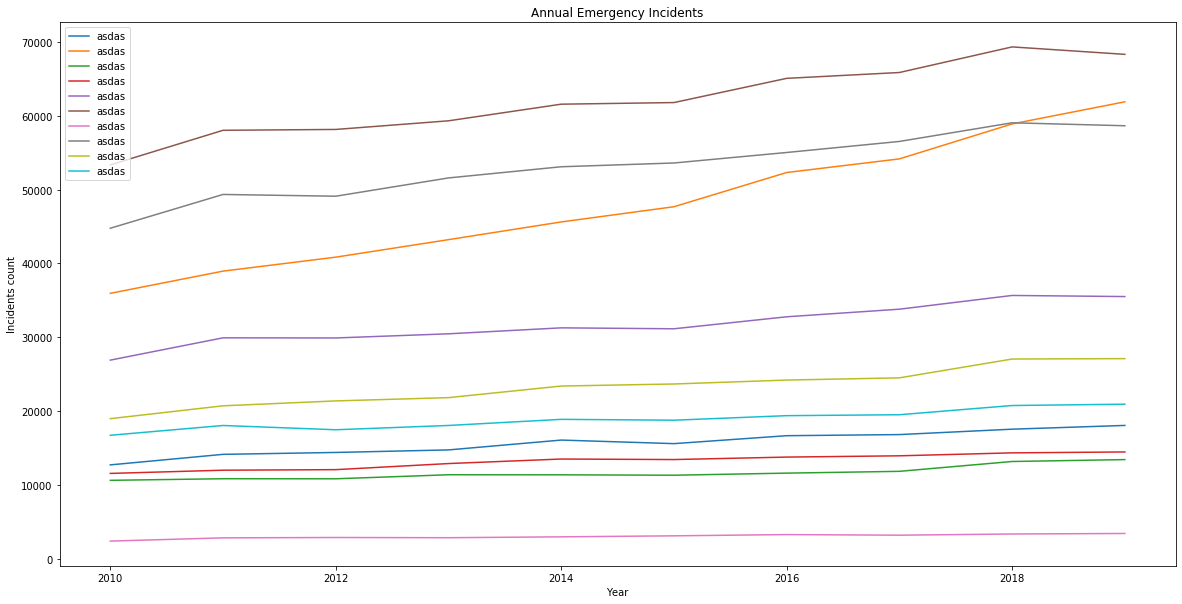

In [17]:
# remove
fig, ax = plt.subplots()
x_years = [*range(2010, 2020)]

fig.set_figheight(10)
fig.set_figwidth(20)

for row in rows:
    ax.plot(x_years, row, label = 'asdas')

ax.set(xlabel='Year', ylabel='Incidents count', title='Annual Emergency Incidents')
plt.legend()

visualize annual growth

In [64]:
fig, ax = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(20)

for index, row in data_df.iterrows():
    ax.plot(x_years, [*row[3:13]], label = row['Borough'])

ax.set(xlabel='Year', ylabel='Incidents count', title='Annual Emergency Incidents')
plt.legend()

plt.show()

NameError: name 'plt' is not defined

as we can observe incident growth is linear, so we can use linear regression for values prediction

In [23]:
tor_lat = 43.653963
tor_lon = -79.387207

In [1]:
normalizer = data_df.max(numeric_only = True)

NameError: name 'data_df' is not defined

In [18]:
values = []
for year in x_years:
    values.append(zip(data_df['Latitude'], data_df['Longihtude'], data_df[str(year)]))

NameError: name 'data_df' is not defined

In [84]:
tor_map = folium.Map(location=[tor_lat, tor_lon], zoom_start=11)

In [ ]:
HeatMapWithTime(df_hour_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(tor_map)

In [ ]:
tor_map